
[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\sansa\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1
test columns : 
 
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

 
 train columns : 
 
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

 TRAIN: 1,296,675 rows × 22 columns
 TEST: 555,719 rows × 22 columns

 Columns:
['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 

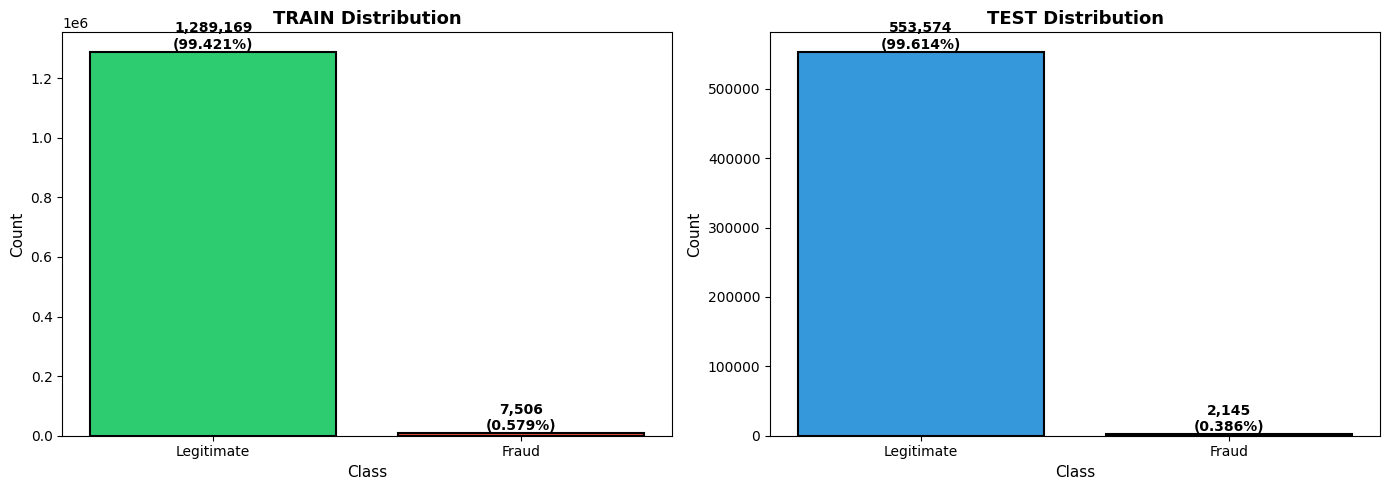


4. KEY FEATURES

 Feature types:
   Numeric: 9
   Categorical: 12

 Amount (amt) statistics:
   Mean: $70.35
   Median: $47.52
   Std: $160.32
   Range: $1.00 - $28948.90

   By class:
   Legitimate: $67.67
   Fraud: $531.32

 Time period:
   From: 2019-01-01 00:00:18
   To: 2020-06-21 12:13:37
   Duration: 537 days

 Numeric features summary:
                    mean           std           min           max
cc_num      4.171920e+17  1.308806e+18  6.041621e+10  4.992346e+18
amt         7.035104e+01  1.603160e+02  1.000000e+00  2.894890e+04
zip         4.880067e+04  2.689322e+04  1.257000e+03  9.978300e+04
lat         3.853762e+01  5.075808e+00  2.002710e+01  6.669330e+01
long       -9.022634e+01  1.375908e+01 -1.656723e+02 -6.795030e+01
city_pop    8.882444e+04  3.019564e+05  2.300000e+01  2.906700e+06
unix_time   1.349244e+09  1.284128e+07  1.325376e+09  1.371817e+09
merch_lat   3.853734e+01  5.109788e+00  1.902779e+01  6.751027e+01
merch_long -9.022646e+01  1.377109e+01 -1.666712e+


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Path to dataset files: C:\Users\sansa\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1
test columns : 
 
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

 
 train columns : 
 
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

 TRAIN: 1,296,675 rows × 22 columns
 TEST: 555,719 rows × 22 columns

 Columns:
['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_nu

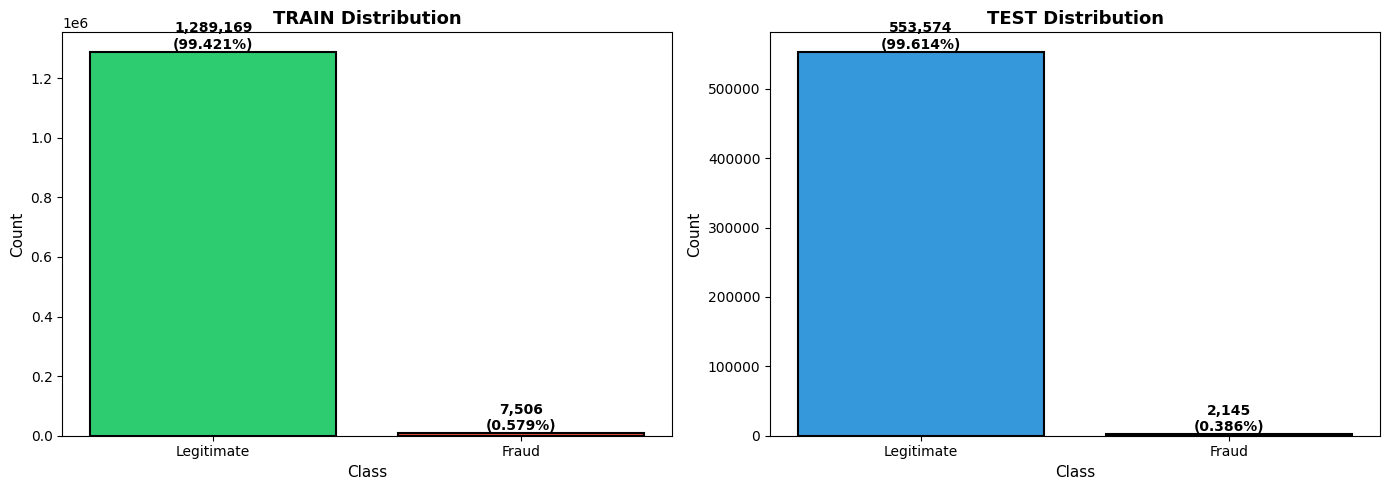


4. KEY FEATURES

 Feature types:
   Numeric: 9
   Categorical: 12

 Amount (amt) statistics:
   Mean: $70.35
   Median: $47.52
   Std: $160.32
   Range: $1.00 - $28948.90

   By class:
   Legitimate: $67.67
   Fraud: $531.32

 Time period:
   From: 2019-01-01 00:00:18
   To: 2020-06-21 12:13:37
   Duration: 537 days

 Numeric features summary:
                    mean           std           min           max
cc_num      4.171920e+17  1.308806e+18  6.041621e+10  4.992346e+18
amt         7.035104e+01  1.603160e+02  1.000000e+00  2.894890e+04
zip         4.880067e+04  2.689322e+04  1.257000e+03  9.978300e+04
lat         3.853762e+01  5.075808e+00  2.002710e+01  6.669330e+01
long       -9.022634e+01  1.375908e+01 -1.656723e+02 -6.795030e+01
city_pop    8.882444e+04  3.019564e+05  2.300000e+01  2.906700e+06
unix_time   1.349244e+09  1.284128e+07  1.325376e+09  1.371817e+09
merch_lat   3.853734e+01  5.109788e+00  1.902779e+01  6.751027e+01
merch_long -9.022646e+01  1.377109e+01 -1.666712e+

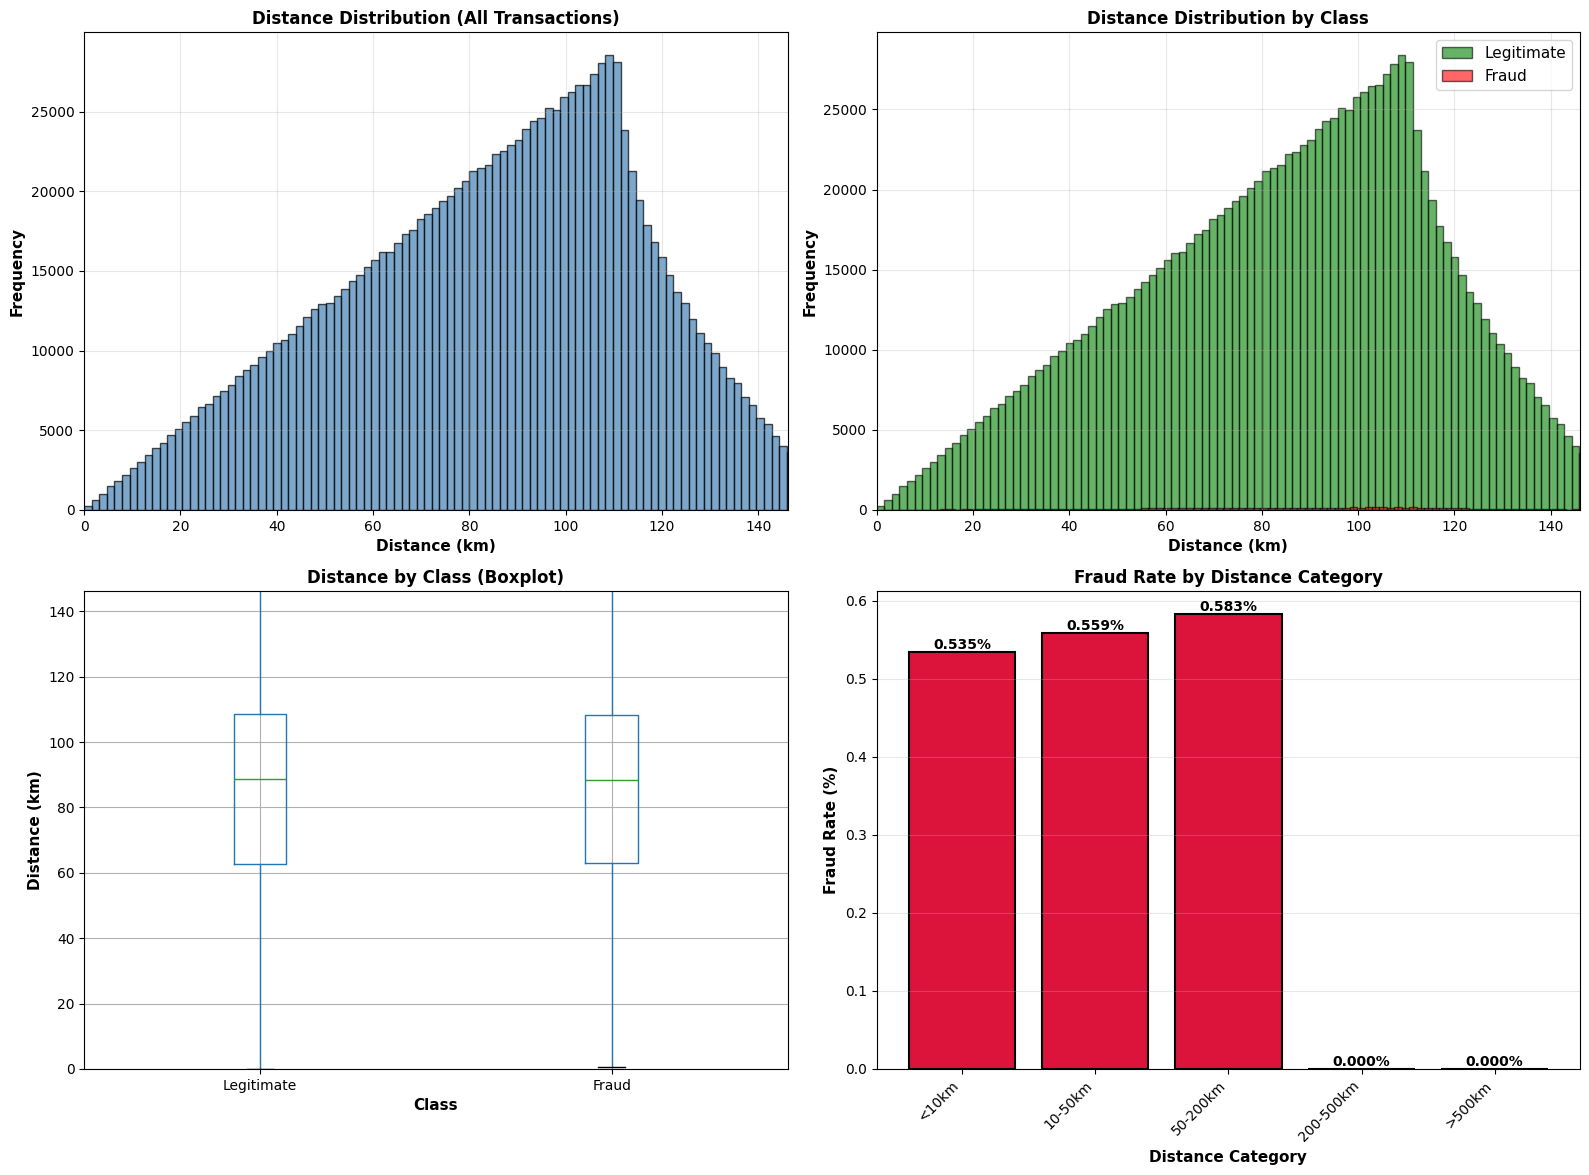


 What we created:
   • distance_km: Euclidean distance between customer and merchant

 Key findings:
   • Mean distance (Legitimate): 84.99 km
   • Mean distance (Fraud): 85.17 km

 Current shapes:
   TRAIN: (1296675, 25)
   TEST: (555719, 25)
Age statistics :
count    1.296675e+06
mean     4.602318e+01
std      1.734874e+01
min      1.800000e+01
25%      3.259959e+01
50%      4.396988e+01
75%      5.707050e+01
max      9.563860e+01
Name: age, dtype: float64
count    555719.000000
mean         46.905700
std          17.400883
min          18.000000
25%          33.448323
50%          44.908966
75%          58.056126
max          96.169747
Name: age, dtype: float64

Distribution :
age_category
Adults (25-50)    718038
Old (>50)         456949
Young (18-25)     121688
Name: count, dtype: int64
age_category
Adults (25-50)    304430
Old (>50)         204922
Young (18-25)      46367
Name: count, dtype: int64

Mean age for each category :
           mean  median    std
is_fraud             

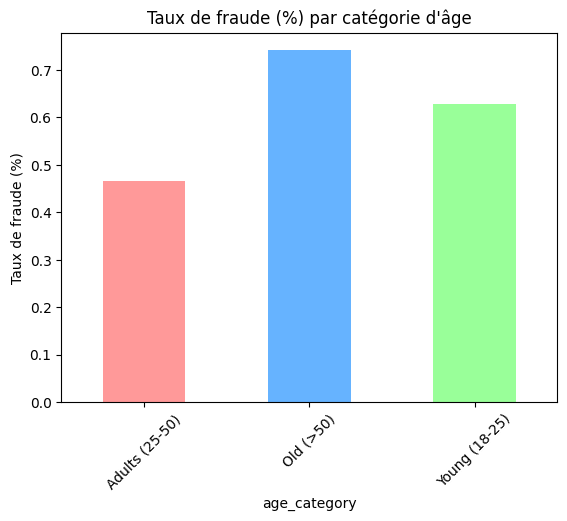


 Categorical columns : 7
 •merchant: 693 unique values
 •category: 14 unique values
 •gender: 2 unique values
 •city: 894 unique values
 •state: 51 unique values
 •job: 494 unique values
 •age_category: 3 unique values

 Gender encoded:
F -> 0
M -> 1

 After encoding:
gender
0    709863
1    586812
Name: count, dtype: int64

 Split complété (avant encodage cible):
   Train full: (1037340, 25) - pour encodage et training
   Validation: (259335, 25) - pour tuning
   Test: (555719, 26) - final eval (inchangé)

 Vérif distribution classes:
   Train full: 6,005 fraudes / 1,037,340 = 0.579%
   Val: 1,501 fraudes / 259,335 = 0.579%
   Test: 2,145 fraudes / 555,719 = 0.386%
    Attention: Légères différences

 Split complété (avant encodage cible):
   Train full: (1037340, 25) - pour encodage et training
   Validation: (259335, 25) - pour tuning
   Test: (555719, 26) - final eval (inchangé)

 Vérif distribution classes:
   Train full: 6,005 fraudes / 1,037,340 = 0.579%
   Val: 1,501 fraudes /

  File "c:\Users\sansa\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



 AFTER SMOTE:
   Class 0 (legitimate): 1,031,335
   Class 1 (fraud):      309,400
   Ratio: 3.3:1

 Size changes:
   Before: 1,037,340 samples
   After:  1,340,735 samples
   Added:  303,395 synthetic frauds


In [1]:
%run eda_analysis.ipynb
%run preprocessing_loader_v2.ipynb

**LightGBM CODE**

Librairies


In [2]:

import pandas as pd 
import numpy as np 
from lightgbm import LGBMClassifier
from sklearn.metrics import (f1_score, precision_score, recall_score,roc_auc_score,average_precision_score,confusion_matrix,classification_report)
import matplotlib.pyplot as plt 
import seaborn as sns 
from time import time 
import optuna 
import lightgbm as lgb
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



Loading data

In [3]:
# Load training data (Original and SMOTE)

X_train_original = X_train_full
y_train_original = y_train_full

X_train_smote = X_train_resampled
y_train_smote = y_train_resampled

print(f"   Original train: {X_train_original.shape}")
print(f"   SMOTE train: {X_train_smote.shape}")
print(f"   Validation: {X_val.shape}")

   Original train: (1037340, 73)
   SMOTE train: (1340735, 73)
   Validation: (259335, 73)


**-------------------------------------------------- WITHOUT SMOTE --------------------------------------------------** 

First training

Class imbalance ratio : 171.7:1
scale_pos_weight: 171.7
Trained in 1.75 seconds
 

F1-Score:          24.6062 %
Precision:         14.1756 %
Recall:            93.1379 %
ROC-AUC:           96.8153 %
PR-AUC:            28.8784 %


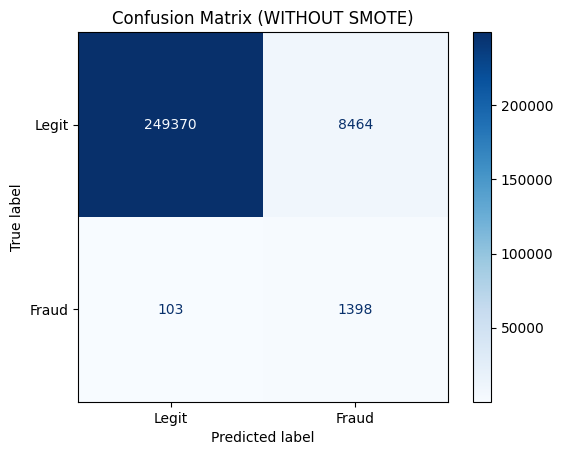

In [4]:
# Calculate scale_pos_weight
scale = (y_train_original == 0).sum() / (y_train_original == 1).sum()
print(f"Class imbalance ratio : {scale:.1f}:1")
print(f"scale_pos_weight: {scale:.1f}")


# Initialize LightGBM 

lgbm_base = LGBMClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    scale_pos_weight = scale,
    min_child_samples=20,
    min_child_weight=0.001,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    n_jobs = -1,
    random_state=42,
    verbose =-1,
)

start_time = time()
lgbm_base.fit(X_train_original, y_train_original)
training_time_base = time() - start_time

print(f"Trained in {training_time_base:.2f} seconds\n \n")

# Predictions

y_pred_base = lgbm_base.predict(X_val)
y_pred_proba_base = lgbm_base.predict_proba(X_val)[:,1]

print(f"F1-Score:          {f1_score(y_val, y_pred_base)*100:.4f} %")
print(f"Precision:         {precision_score(y_val, y_pred_base)*100:.4f} %")
print(f"Recall:            {recall_score(y_val, y_pred_base)*100:.4f} %")
print(f"ROC-AUC:           {roc_auc_score(y_val, y_pred_proba_base)*100:.4f} %")
print(f"PR-AUC:            {average_precision_score(y_val, y_pred_proba_base)*100:.4f} %")

cm1 = confusion_matrix(y_val, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (WITHOUT SMOTE)')
plt.show()

Optimisation using Optuna 

In [5]:
def objective(trial):
    params = {
        'objective':'binary',
        'metric':'binary_logloss',
        'n_estimators': 50,
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': scale, 
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    model = LGBMClassifier(**params)

    model.fit(X_train_original, y_train_original, eval_set=[(X_val, y_val)],
              eval_metric='f1')
    
    y_pred = model.predict(X_val)
    score = f1_score(y_val,y_pred)

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

# 3. Display results
print("Trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value (F1-Score): ", trial.value)
print("  Best params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params

[I 2025-10-30 18:46:07,869] A new study created in memory with name: no-name-005d38ae-2cca-412f-82b8-a1778536ee44


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-30 18:46:10,457] Trial 0 finished with value: 0.27662736550084216 and parameters: {'learning_rate': 0.02648714719587851, 'num_leaves': 122, 'max_depth': 5, 'min_child_samples': 90, 'subsample': 0.6209670287233758, 'colsample_bytree': 0.8878724456936913, 'reg_alpha': 0.8223307012184908, 'reg_lambda': 9.43150709487772e-07}. Best is trial 0 with value: 0.27662736550084216.
[I 2025-10-30 18:46:13,261] Trial 1 finished with value: 0.34486094316807736 and parameters: {'learning_rate': 0.029286563489325658, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 48, 'subsample': 0.9723206527707045, 'colsample_bytree': 0.6681546405580987, 'reg_alpha': 1.4579829494495995e-06, 'reg_lambda': 5.676639664141077e-07}. Best is trial 1 with value: 0.34486094316807736.
[I 2025-10-30 18:46:15,277] Trial 2 finished with value: 0.17347588137966144 and parameters: {'learning_rate': 0.13444902873271214, 'num_leaves': 113, 'max_depth': 5, 'min_child_samples': 40, 'subsample': 0.8251140144257745, 'c

After optimization

In [6]:
# Initialize LightGBM 

lgbm_base_new = LGBMClassifier(
    n_estimators=50,
    learning_rate=0.045498527992294334,
    max_depth=10,
    num_leaves=141,
    scale_pos_weight = scale,
    min_child_samples=61,
    min_child_weight=0.001,
    subsample=0.890923497210552,
    colsample_bytree=0.7291315965375645,
    reg_alpha= 0.0006260046088932341,
    reg_lambda=0.0004326548208585303,
    n_jobs = -1,
    random_state=42,
    verbose = -1,
)

start_time = time()
lgbm_base_new.fit(X_train_original, y_train_original)
training_time_base = time() - start_time

print(f"Trained in {training_time_base:.2f} seconds\n \n")

# Predictions

y_pred_base_new = lgbm_base_new.predict(X_val)
y_pred_proba_base_new = lgbm_base_new.predict_proba(X_val)[:,1]

print(f"F1-Score:          {f1_score(y_val, y_pred_base_new)*100:.4f} %")
print(f"Precision:         {precision_score(y_val, y_pred_base_new)*100:.4f} %")
print(f"Recall:            {recall_score(y_val, y_pred_base_new)*100:.4f} %")
print(f"ROC-AUC:           {roc_auc_score(y_val, y_pred_proba_base_new)*100:.4f} %")
print(f"PR-AUC:            {average_precision_score(y_val, y_pred_proba_base_new)*100:.4f} %")

Trained in 2.62 seconds
 

F1-Score:          45.5269 %
Precision:         29.9101 %
Recall:            95.2698 %
ROC-AUC:           99.6049 %
PR-AUC:            89.7705 %


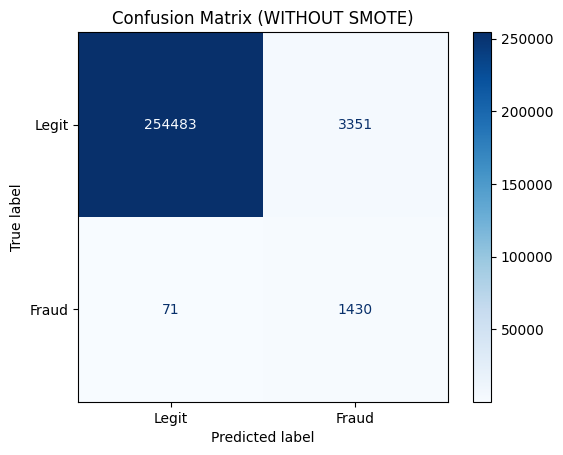

In [7]:
cm = confusion_matrix(y_val, y_pred_base_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (WITHOUT SMOTE)')
plt.show()

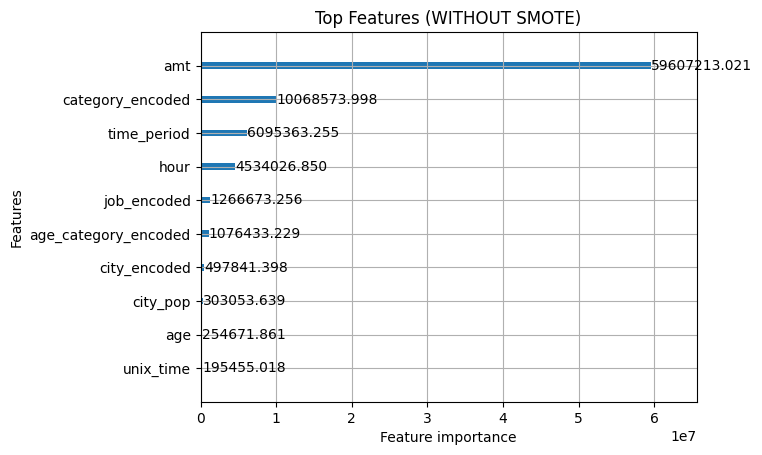

In [8]:
lgb.plot_importance(lgbm_base_new, max_num_features=10, importance_type='gain')
plt.title('Top Features (WITHOUT SMOTE)')
plt.show()

**-------------------------------------------------- WITH SMOTE --------------------------------------------------** 

[I 2025-10-30 18:47:31,621] A new study created in memory with name: no-name-e09e8b8d-f6f6-4cf1-9236-f191fe8d9d6c


--- Optuna optimisation for SMOTE ---\n


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-30 18:47:34,642] Trial 0 finished with value: 0.7341991341991342 and parameters: {'learning_rate': 0.08799973210726066, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 98, 'subsample': 0.6446570717863277, 'colsample_bytree': 0.792702070254675, 'reg_alpha': 2.601417808046784, 'reg_lambda': 0.7901760003785471}. Best is trial 0 with value: 0.7341991341991342.
[I 2025-10-30 18:47:37,497] Trial 1 finished with value: 0.5902182923459519 and parameters: {'learning_rate': 0.010341806618729523, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 60, 'subsample': 0.832968669972384, 'colsample_bytree': 0.9913112497089389, 'reg_alpha': 0.004074454357810175, 'reg_lambda': 5.189646558439603e-05}. Best is trial 0 with value: 0.7341991341991342.
[I 2025-10-30 18:47:41,196] Trial 2 finished with value: 0.7491638795986622 and parameters: {'learning_rate': 0.024904810239791696, 'num_leaves': 129, 'max_depth': 10, 'min_child_samples': 79, 'subsample': 0.704645558822661, 'colsample_by

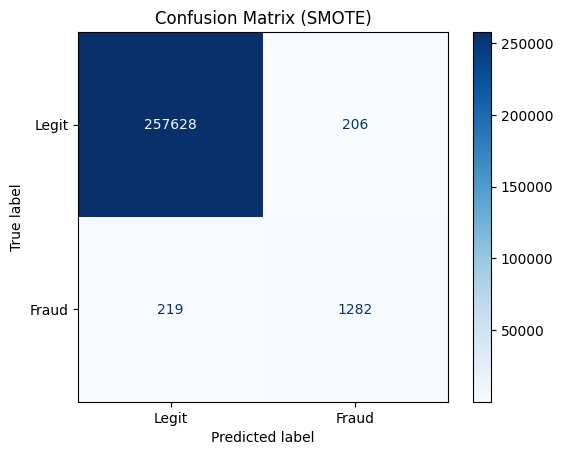

In [9]:
def objective_smote(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'n_estimators': 50,
        'random_state': 42,
        'n_jobs': -1,        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    model = LGBMClassifier(**params)
    
    # SMOTE training
    model.fit(X_train_resampled, y_train_resampled, 
              eval_set=[(X_val, y_val)],
              eval_metric='f1',
              ) 
    
    # Predictions
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred)

    return score

# Optimization
print("--- Optuna optimisation for SMOTE ---\\n")
study_smote = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_smote.optimize(objective_smote, n_trials=30, show_progress_bar=True) 

# Best results display
print("\\n--- Best hyperparameters found for SMOTE ---")
best_params_smote = study_smote.best_trial.params
for key, value in best_params_smote.items():
    print(f"    {key}: {value}")

# Optimized SMOTE training
print("\\n--- SMOTE training with optimized hyperparameters ---")
lgbm_smote_best = LGBMClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1,
    **best_params_smote
)

start_time = time()
lgbm_smote_best.fit(X_train_resampled, y_train_resampled)
training_time_smote = time() - start_time
print(f"Trained in {training_time_smote:.2f} seconds\\n")

y_pred_smote_best = lgbm_smote_best.predict(X_val)
y_pred_proba_smote_best = lgbm_smote_best.predict_proba(X_val)[:, 1]

print("--- Performances (SMOTE optimized)---")
print(f"F1-Score:          {f1_score(y_val, y_pred_smote_best) * 100:.4f} %")
print(f"Precision:         {precision_score(y_val, y_pred_smote_best) * 100:.4f} %")
print(f"Recall:            {recall_score(y_val, y_pred_smote_best) * 100:.4f} %")
print(f"ROC-AUC:           {roc_auc_score(y_val, y_pred_proba_smote_best) * 100:.4f} %")
print(f"PR-AUC:            {average_precision_score(y_val, y_pred_proba_smote_best) * 100:.4f} %\\n")

cm3 = confusion_matrix(y_val, y_pred_smote_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (SMOTE)')
plt.show()


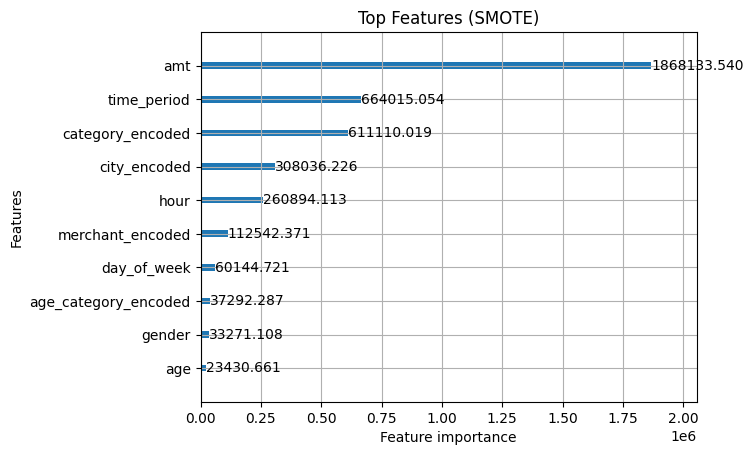

In [10]:
lgb.plot_importance(lgbm_smote_best, max_num_features=10, importance_type='gain')
plt.title('Top Features (SMOTE)')
plt.show()

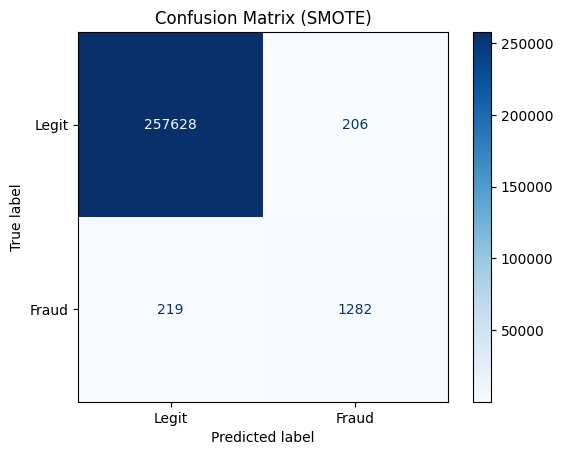

In [11]:
cm = confusion_matrix(y_val, y_pred_smote_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (SMOTE)')
plt.show()

**COMPARISON**

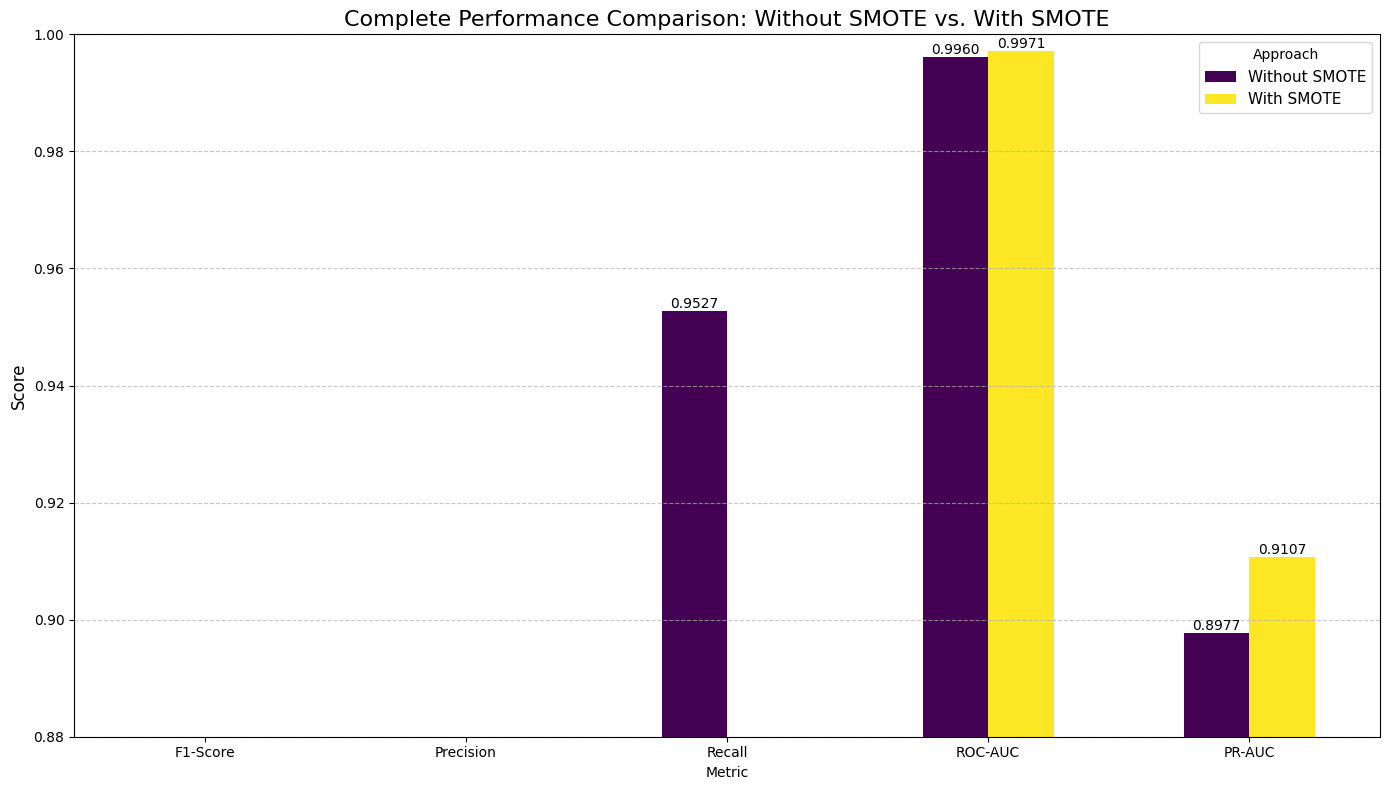

In [12]:
# Create a DataFrame for visualization
metrics_data = {
    'Metric': ['F1-Score', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC'],
    'Without SMOTE': [
        f1_score(y_val, y_pred_base_new),
        precision_score(y_val, y_pred_base_new),
        recall_score(y_val, y_pred_base_new),
        roc_auc_score(y_val, y_pred_proba_base_new),
        average_precision_score(y_val, y_pred_proba_base_new)
    ],
    'With SMOTE': [
        f1_score(y_val, y_pred_smote_best),
        precision_score(y_val, y_pred_smote_best),
        recall_score(y_val, y_pred_smote_best),
        roc_auc_score(y_val, y_pred_proba_smote_best),
        average_precision_score(y_val, y_pred_proba_smote_best)
    ]
}
df_metrics = pd.DataFrame(metrics_data).set_index('Metric')

# Create the plot
ax = df_metrics.plot(kind='bar', figsize=(14, 8), rot=0, colormap='viridis')
plt.title('Complete Performance Comparison: Without SMOTE vs. With SMOTE', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.88, 1.0) # Adjust the y-axis limit to better visualize differences
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='{:.4f}')

plt.legend(title='Approach', fontsize=11)
plt.tight_layout()

# Display the plot
plt.show()

Entraîné en 4.46 secondes

--- Performances (SMOTE par défaut) ---
F1-Score:     82.1802 %
Precision:    80.5502 %
Recall:       83.8774 %
ROC-AUC:      99.5495 %

PR-AUC:      88.6352 %



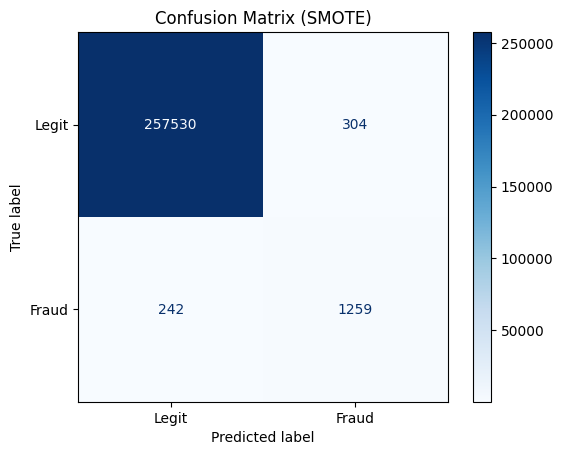

In [13]:
import time as time
lgbm_smote_default = LGBMClassifier(
    random_state=42,
    n_jobs=-1
    # Note : Tous les autres paramètres sont laissés par défaut
)

start_time = time.time()
lgbm_smote_default.fit(X_train_resampled, y_train_resampled)
training_time_default = time.time() - start_time
print(f"Entraîné en {training_time_default:.2f} secondes\n")

# Prédictions du modèle de base
y_pred_smote_default = lgbm_smote_default.predict(X_val)
y_pred_proba_smote_default = lgbm_smote_default.predict_proba(X_val)[:, 1]

# Affichage des performances de base
print("--- Performances (SMOTE par défaut) ---")
print(f"F1-Score:     {f1_score(y_val, y_pred_smote_default) * 100:.4f} %")
print(f"Precision:    {precision_score(y_val, y_pred_smote_default) * 100:.4f} %")
print(f"Recall:       {recall_score(y_val, y_pred_smote_default) * 100:.4f} %")
print(f"ROC-AUC:      {roc_auc_score(y_val, y_pred_proba_smote_default) * 100:.4f} %\n")
print(f"PR-AUC:      {average_precision_score(y_val, y_pred_proba_smote_default) * 100:.4f} %\n")

# --- VOTRE MATRICE DE CONFUSION "AVANT" ---
# Utiliser un cmap différent (ex: 'Oranges') pour la différencier visuellement
cm_default = confusion_matrix(y_val, y_pred_smote_default)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['Legit', 'Fraud'])
disp_default.plot(cmap='Blues') 
plt.title('Confusion Matrix (SMOTE)')
plt.show()